# torch: Training Neural Networks for Classification and Dimensionality Reduction

This notebook demonstrates example neural network setups for **image classification** and **dimensionality reduction** tasks using `torch`.

The examples serve as complement and comparison for exploring neural networks with the `edu.yaprnn` app.

Loading MNIST images from E:\edu.yaprnn\src\main\resources\digits.idx3-ubyte


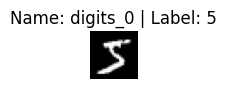

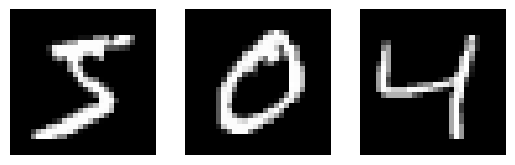

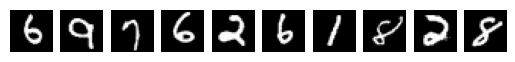

(36000, 784) (36000, 10) (36000,) (12000, 784) (12000, 10) (12000,)
(48000, 784) (48000, 10) (48000,) (12000, 784) (12000, 10) (12000,)
(48000, 784) (48000, 10) (48000,) (12000, 784) (12000, 10) (12000,)


In [1]:
from sklearn.model_selection import train_test_split

import mnist_utils
import model_utils

mnist_images, image_size, X, random_x_indices, random_feature_indices, y, labels = mnist_utils.from_mnist_images()

digits_train_32k_test_12k = train_test_split(X, y, labels, train_size=0.6, test_size=0.2, random_state=model_utils.SEED)
digits_images_from_labels = train_test_split(X, y, labels, train_size=0.8, test_size=0.2, random_state=model_utils.SEED)
digits_input_reconstruction = train_test_split(X, y, labels, train_size=0.8, test_size=0.2,
                                               random_state=model_utils.SEED)

mnist_utils.from_dataset(digits_train_32k_test_12k, explain=True)
mnist_utils.from_dataset(digits_images_from_labels, explain=True)
mnist_utils.from_dataset(digits_input_reconstruction, explain=True)

None

In [14]:
from torch.nn import Sequential, Linear, GELU, MSELoss
from torch.optim import SGD, Optimizer, Adagrad
from torch.utils.data import DataLoader, TensorDataset
from tqdm import trange
import numpy as np
import numpy.typing as npt
import torch
import typing as tp


def count_parameters(model: torch.nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def to_tensor(x: npt.NDArray) -> torch.Tensor:
    return torch.tensor(x, dtype=torch.float32).to(device)


def to_numpy(x: torch.Tensor) -> npt.NDArray:
    return x.cpu().numpy()


def defer_forward_to_numpy(model: torch.nn.Module) -> tp.Callable[[torch.Tensor], npt.NDArray]:
    def forward_to_numpy(X_tensor: torch.Tensor) -> npt.NDArray:
        with torch.no_grad():
            return to_numpy(model.forward(X_tensor))

    return forward_to_numpy


def train_step(model: torch.nn.Module, optimizer: Optimizer, loss: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    optimizer.zero_grad()
    loss(model(X), y).backward()
    optimizer.step()


device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_type)
print(f'Using device: {device}')

preferred_batch_size = model_utils.BATCH_SIZE * (4 if device_type == 'cuda' else 1)
preferred_learning_rate = model_utils.LEARNING_RATE
print(f'Preferred batch size and batch learning rate: {preferred_batch_size}, {preferred_learning_rate}')

Using device: cuda
Preferred batch size and batch learning rate: 128, 0.02


## Digits Classification

This model is configured as follows:

- **Architecture**:
  - Input layer: 784 neurons
  - 2 hidden layers:
    - Layer 1: 20 neurons
    - Layer 2: 15 neurons
  - Output layer: 10 neurons
  - Total parameters: `((784 + 1) * 20) + ((20 + 1) * 15) + ((15 + 1) * 10) = 16175` (Biases included)
- **Activation Function**: gelu
- **Optimizer**: Stochastic Gradient Descent (SGD)
  - Learning rate: 0.02
  - Momentum: 0.2 with Nesterov term
  - L2-weight-decay: 0.001
  - L1-weight-decay: not implemented
- **Loss Function**: Mean Squared Error (MSE)

Training progress: 100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


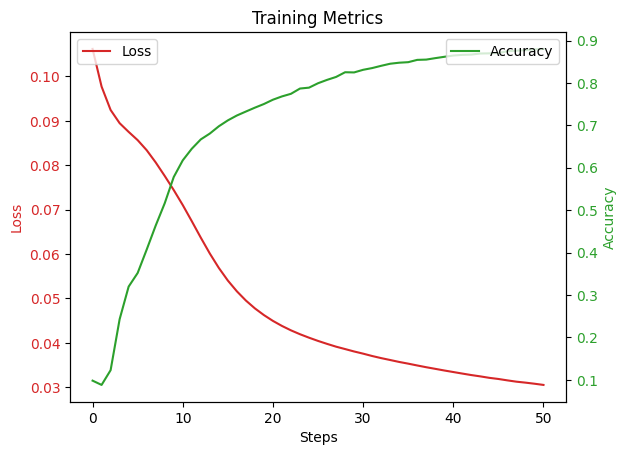

Actual number of parameters: 16175


In [3]:
input_size, output_size, X_train, y_train, X_test, y_test = mnist_utils.from_dataset(digits_train_32k_test_12k)
X_train_tensor = to_tensor(X_train)
y_train_tensor = to_tensor(y_train)
X_test_tensor = to_tensor(X_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=preferred_batch_size, shuffle=True)

classification_model = Sequential(
    Linear(input_size, model_utils.CLASSIFICATION_FEATURES[0]),
    GELU(),
    Linear(model_utils.CLASSIFICATION_FEATURES[0], model_utils.CLASSIFICATION_FEATURES[1]),
    GELU(),
    Linear(model_utils.CLASSIFICATION_FEATURES[1], output_size),
    GELU()
).to(device)
classification_model_predict = defer_forward_to_numpy(classification_model)

classification_optimizer = SGD(classification_model.parameters(), lr=preferred_learning_rate,
                               momentum=model_utils.MOMENTUM, nesterov=model_utils.NESTEROV_MOMENTUM,
                               weight_decay=model_utils.L2_DECAY)
classification_loss = MSELoss()

classification_model.train()
epoch_loss = [model_utils.mse_loss(classification_model_predict, X_test_tensor, y_test)]
epoch_accuracy = [model_utils.calculate_accuracy(classification_model_predict, X_test_tensor, y_test)]
for epoch in trange(model_utils.CLASSIFICATION_EPOCHS, desc='Training progress'):
    for X_batch, y_batch in train_loader:
        train_step(classification_model, classification_optimizer, classification_loss, X_batch, y_batch)
    epoch_loss.append(model_utils.mse_loss(classification_model_predict, X_test_tensor, y_test))
    epoch_accuracy.append(model_utils.calculate_accuracy(classification_model_predict, X_test_tensor, y_test))

model_utils.plot_training_metrics(epoch_loss, epoch_accuracy)
print(f'Actual number of parameters: {count_parameters(classification_model)}')

Accuracy on training set: 0.8806666666666667
Accuracy on test set: 0.88025
Random test indices: [3884 8746 2204  188 5153]


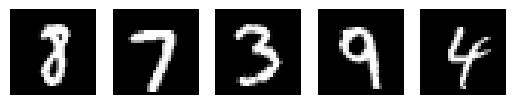

Actual labels of random test indices: [8 7 3 9 4]
Predicted labels of random test indices: [8 7 3 9 4]


array([['-0.06', '0.08', '0.17', '0.23', '-0.12', '-0.11', '-0.09',
        '0.09', '0.29', '0.01'],
       ['-0.02', '-0.11', '0.08', '0.08', '-0.11', '-0.09', '-0.1',
        '1.09', '-0.07', '0.23'],
       ['-0.1', '0.03', '-0.09', '1.24', '-0.04', '0.08', '-0.11', '0.1',
        '-0.09', '-0.1'],
       ['-0.14', '-0.05', '0.03', '0.17', '0.19', '-0.01', '-0.09',
        '0.12', '-0.06', '0.69'],
       ['-0.03', '-0.01', '-0.04', '-0.03', '0.63', '-0.01', '0.07',
        '0.09', '-0.05', '0.25']], dtype='<U32')

In [4]:
classification_model.eval()

_, _, X_train, y_train, X_test, y_test = mnist_utils.from_dataset(digits_train_32k_test_12k)
X_train_tensor = to_tensor(X_train)
X_test_tensor = to_tensor(X_test)

print(
    f'Accuracy on training set: {model_utils.calculate_accuracy(classification_model_predict, X_train_tensor, y_train)}')
print(f'Accuracy on test set: {model_utils.calculate_accuracy(classification_model_predict, X_test_tensor, y_test)}')

random_test_indices = np.random.choice(X_test.shape[0], 5, replace=False)
print(f'Random test indices: {random_test_indices}')

mnist_utils.plot_images(X_test[random_test_indices], image_size=image_size, cmap='gray')
print(f'Actual labels of random test indices: {np.argmax(y_test[random_test_indices], axis=1)}')

predicted = classification_model_predict(to_tensor(X_test[random_test_indices]))
print(f'Predicted labels of random test indices: {np.argmax(predicted, axis=1)}')
predicted.round(2).astype('str')

## Dimensionality Reduction with an Autoencoder

This section demonstrates the use of two neural networks for dimensionality reduction. These networks rely on a bottleneck layer in their architecture to reduce the input data's dimensionality.

Instead of using predefined methods to extract the most relevant features, the networks are trained using backpropagation. This approach enables the model to automatically learn a transformation into a compressed feature space along with its inverse transformation to reconstruct the input data as accurately as possible.

### Autoencoder Network with 12 Neurons Bottleneck Layer

This model is configured as follows:

- **Architecture**:
  - Input layer: 784 neurons
  - 5 hidden layers:
    - Layer 1: 196 neurons
    - Layer 2: 49 neurons
    - Layer 3: 12 neurons
    - Layer 4: 49 neurons
    - Layer 5: 196 neurons
  - Output layer: 784 neurons
  - Total parameters: 328998 (Biases included)
- **Activation Function**: gelu
- **Optimizer**: Stochastic Gradient Descent (SGD)
  - Learning rate: 0.02
  - Momentum: 0.2 with Nesterov term
  - L2-weight-decay: 0.01 * 0.001 (too big values break training)
  - L1-weight-decay: not implemented
- **Loss Function**: Mean Squared Error (MSE)

Training progress: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


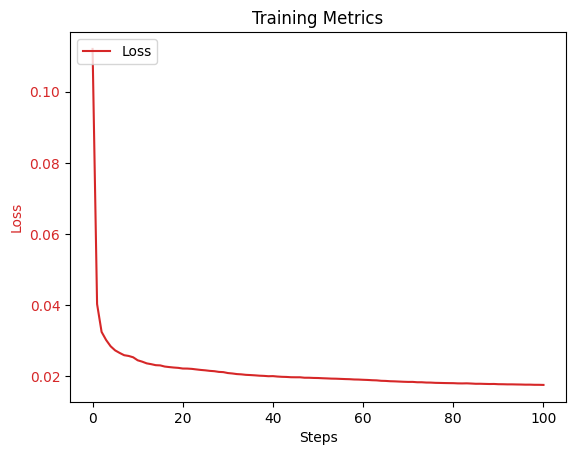

Actual number of parameters: 328998


In [15]:
input_size, output_size, X_train, _, X_test, _ = mnist_utils.from_dataset(digits_input_reconstruction)
X_train_tensor = to_tensor(X_train)
X_test_tensor = to_tensor(X_test)

train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=preferred_batch_size, shuffle=True)

autoencoder_model = Sequential(
    Linear(input_size, 196),
    GELU(),
    Linear(196, 49),
    GELU(),
    Linear(49, 12),
    GELU(),
    Linear(12, 49),
    GELU(),
    Linear(49, 196),
    GELU(),
    Linear(196, input_size),
    GELU()
).to(device)
autoencoder_model_predict = defer_forward_to_numpy(autoencoder_model)

autoencoder_optimizer = SGD(autoencoder_model.parameters(), lr=preferred_learning_rate, momentum=model_utils.MOMENTUM,
                            nesterov=model_utils.NESTEROV_MOMENTUM, weight_decay=0.01 * model_utils.L2_DECAY)
autoencoder_optimizer = Adagrad(autoencoder_model.parameters(), lr=preferred_learning_rate,
                                weight_decay=0.01 * model_utils.L2_DECAY)
autoencoder_loss = MSELoss()

autoencoder_model.train()
epoch_loss = [model_utils.mse_loss(autoencoder_model_predict, X_test_tensor, X_test)]
for epoch in trange(model_utils.AUTOENCODER_EPOCHS, desc='Training progress'):
    for X_batch, y_batch in train_loader:
        train_step(autoencoder_model, autoencoder_optimizer, autoencoder_loss, X_batch, y_batch)
    epoch_loss.append(model_utils.mse_loss(autoencoder_model_predict, X_test_tensor, X_test))

model_utils.plot_training_metrics(epoch_loss)
print(f'Actual number of parameters: {count_parameters(autoencoder_model)}')

Loss X_train: 0.017311211675405502
Loss X_test: 0.017629262059926987
Random test indices: [ 5872 10582 10928  1360 10230]


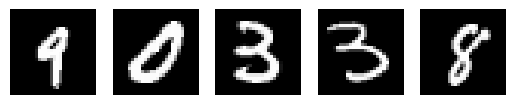

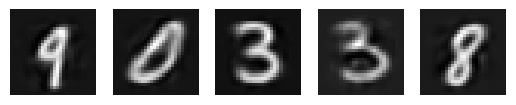

In [16]:
autoencoder_model.eval()

_, _, X_train, _, X_test, _ = mnist_utils.from_dataset(digits_input_reconstruction)
X_train_tensor = to_tensor(X_train)
X_test_tensor = to_tensor(X_test)

print(f'Loss X_train: {model_utils.mse_loss(autoencoder_model_predict, X_train_tensor, X_train)}')
print(f'Loss X_test: {model_utils.mse_loss(autoencoder_model_predict, X_test_tensor, X_test)}')

random_test_indices = np.random.choice(X_test.shape[0], 5, replace=False)
print(f'Random test indices: {random_test_indices}')

original = X_test[random_test_indices]
mnist_utils.plot_images(original, image_size=image_size, cmap='gray')

restored = autoencoder_model_predict(to_tensor(original))
mnist_utils.plot_images(restored, image_size=image_size, cmap='gray')